In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy
import requests

In [21]:
df_walk = pd.read_csv('../data/walkability.csv')

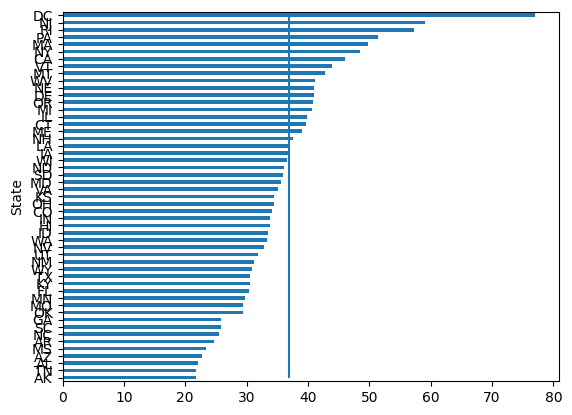

In [28]:
ax = (
    df_walk.groupby('State')['Walk Score'].mean()
    .sort_values(ascending=True)
    .plot
    .barh()
)

ax.vlines(df_walk['Walk Score'].mean(), 0, 1000)

## Activity (CDC) data

In [48]:
df_nutri = pd.read_csv("../data/nutrition_activity.csv")

In [50]:
df_nutri.head()

,YearStart,YearEnd,LocationAbbr,LocationDesc,Datasource,Class,Topic,Question,Data_Value_Unit,Data_Value_Type,...,GeoLocation,ClassID,TopicID,QuestionID,DataValueTypeID,LocationID,StratificationCategory1,Stratification1,StratificationCategoryId1,StratificationID1
0,2019,2019,AK,Alaska,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who achieve...,NaN,Value,...,"(64.845079957001, -147.722059036)",PA,PA1,Q048,VALUE,2,Race/Ethnicity,Asian,RACE,RACEASN
1,2019,2019,AZ,Arizona,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,"(34.86597028, -111.763811277)",OWS,OWS1,Q038,VALUE,4,Total,Total,OVR,OVERALL
2,2019,2019,DC,District of Columbia,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have ob...,NaN,Value,...,"(38.890371385, -77.031961127)",OWS,OWS1,Q038,VALUE,11,Total,Total,OVR,OVERALL
3,2019,2019,IL,Illinois,Youth Risk Behavior Surveillance System,Physical Activity,Physical Activity - Behavior,Percent of students in grades 9-12 who partici...,NaN,Value,...,"(40.485010283, -88.997710178)",PA,PA1,Q049,VALUE,17,Grade,10th,GRADE,GRADE10
4,2019,2019,MD,Maryland,Youth Risk Behavior Surveillance System,Obesity / Weight Status,Obesity / Weight Status,Percent of students in grades 9-12 who have an...,NaN,Value,...,"(39.290580964, -76.609260111)",OWS,OWS1,Q039,VALUE,24,Race/Ethnicity,2 or more races,RACE,RACE2PLUS
